
<a href="https://colab.research.google.com/github/takzen/ai-engineering-handbook/blob/main/38_CNN_Computer_Vision.ipynb" target="_parent">
    <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>


# 👁️ CNN: Jak komputer "widzi"? (Sploty)

Zwykła sieć (MLP) niszczy zdjęcia.
Sieć Splotowa (CNN) szanuje ich strukturę (wysokość, szerokość).

CNN składa się z trzech głównych elementów:
1.  **Convolution (Splot/Conv2d):** Filtr (np. 3x3 piksele), który przesuwa się po zdjęciu. Uczy się wykrywać cechy (np. linie pionowe).
2.  **ReLU:** Iskra nieliniowości (usuwa ujemne wartości).
3.  **Pooling (MaxPool2d):** Zmniejszanie obrazka. Wybiera najważniejszy (najjaśniejszy) piksel z obszaru 2x2. Dzięki temu sieć widzi coraz "szerszy" kontekst.

Użyjemy zbioru **FashionMNIST**. To 60,000 zdjęć ubrań (koszulki, buty, torebki). Jest trudniejszy niż cyfry (MNIST), ale nadal czarno-biały (1 kanał koloru).

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

# 1. POBIERANIE DANYCH
# PyTorch ma wbudowane zestawy danych w 'torchvision'
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # Zamienia obrazek (PIL Image) na Tensor
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

# Sprawdźmy co mamy
class_names = train_data.classes
print(f"Klasy: {class_names}")
print(f"Liczba zdjęć treningowych: {len(train_data)}")
print(f"Wymiar jednego zdjęcia: {train_data[0][0].shape} -> [Kanały, Wysokość, Szerokość]")

100%|██████████| 26.4M/26.4M [00:14<00:00, 1.88MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 539kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.23MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.2MB/s]

Klasy: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
Liczba zdjęć treningowych: 60000
Wymiar jednego zdjęcia: torch.Size([1, 28, 28]) -> [Kanały, Wysokość, Szerokość]


## Wizualizacja Danych

Zanim nakarmimy sieć, musimy zobaczyć, co to za zdjęcia.
To małe obrazki 28x28 pikseli w skali szarości.

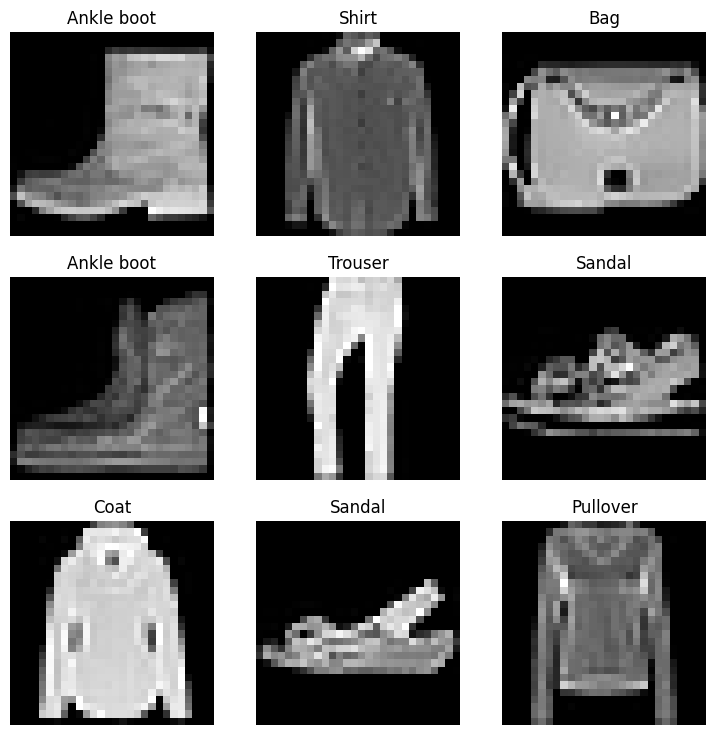

In [2]:
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3

for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray") # squeeze usuwa wymiar koloru [1, 28, 28] -> [28, 28]
    plt.title(class_names[label])
    plt.axis(False)

## DataLoaders (Wsady)

Nie możemy wrzucić 60,000 zdjęć naraz do RAM-u (chyba że masz superkomputer).
Użyjemy **DataLoader**, który dzieli dane na małe paczki (**Batches**).
Typowy Batch Size to 32.
Model uczy się na 32 zdjęciach, poprawia wagi, bierze kolejne 32...

In [3]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"Dataloadery gotowe. Jeden batch to {BATCH_SIZE} zdjęć.")

Dataloadery gotowe. Jeden batch to 32 zdjęć.


## Budujemy CNN (Architektura TinyVGG)

Stworzymy sieć, która naśladuje słynną architekturę VGG (tylko mniejszą).
Blok składa się z: `Conv -> ReLU -> Conv -> ReLU -> MaxPool`.

1.  **Conv2d:** `in_channels=1` (bo czarno-białe), `kernel_size=3` (filtr 3x3).
2.  **MaxPool2d:** Zmniejsza obrazek o połowę (28x28 -> 14x14).
3.  **Flatten:** Na końcu musimy spłaszczyć wynik, żeby podjąć decyzję (Linear).

In [4]:
class FashionCNN(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        # BLOK 1: Wykrywanie prostych cech (krawędzie)
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # Filtr 3x3
                      stride=1,      # Przesuwaj o 1 piksel
                      padding=1),    # Dodaj ramkę zer (żeby nie zmniejszać obrazka)
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) # Zmniejsz obrazek o połowę (28->14)
        )
        
        # BLOK 2: Wykrywanie złożonych cech (kształty)
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2) # Zmniejsz obrazek o połowę (14->7)
        )
        
        # KLASYFIKATOR: Decyzja
        self.classifier = nn.Sequential(
            nn.Flatten(), # Spłaszcz [10, 7, 7] -> [490]
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )
    
    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

# Inicjalizacja
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FashionCNN(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)
print(model)

FashionCNN(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)


## Trening (Na Batches)

Pętla jest podobna do poprzedniej, ale teraz mamy **pętlę w pętli**.
1.  Pętla zewnętrzna: Epoki (przejścia przez cały zbiór).
2.  Pętla wewnętrzna: Batche (paczki po 32 zdjęcia).

In [5]:
loss_fn = nn.CrossEntropyLoss() # Do klasyfikacji wielu klas (But, Koszula, etc.)
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

epochs = 3 

for epoch in range(epochs):
    print(f"--- Epoka {epoch+1} ---")
    
    # TRENING
    model.train()
    train_loss = 0
    
    # Iterujemy przez Batche (Dataloader sam nam je podaje)
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)
        
        # 1. Forward
        y_pred = model(X)
        
        # 2. Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # Sumujemy błędy
        
        # 3. Optimizer step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 400 == 0:
            print(f"Przetworzono {batch * len(X)} / {len(train_dataloader.dataset)} zdjęć")
            
    # Podsumowanie epoki
    train_loss /= len(train_dataloader)
    print(f"Średni błąd treningowy: {train_loss:.4f}")

print("✅ Trening zakończony!")

--- Epoka 1 ---
Przetworzono 0 / 60000 zdjęć
Przetworzono 12800 / 60000 zdjęć
Przetworzono 25600 / 60000 zdjęć
Przetworzono 38400 / 60000 zdjęć
Przetworzono 51200 / 60000 zdjęć
Średni błąd treningowy: 0.6443
--- Epoka 2 ---
Przetworzono 0 / 60000 zdjęć
Przetworzono 12800 / 60000 zdjęć
Przetworzono 25600 / 60000 zdjęć
Przetworzono 38400 / 60000 zdjęć
Przetworzono 51200 / 60000 zdjęć
Średni błąd treningowy: 0.3823
--- Epoka 3 ---
Przetworzono 0 / 60000 zdjęć
Przetworzono 12800 / 60000 zdjęć
Przetworzono 25600 / 60000 zdjęć
Przetworzono 38400 / 60000 zdjęć
Przetworzono 51200 / 60000 zdjęć
Średni błąd treningowy: 0.3430
✅ Trening zakończony!


In [6]:
# TESTOWANIE
model.eval()
correct = 0

with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        test_pred = model(X)
        
        # Zamieniamy logity na konkretną klasę (argmax wybiera najwyższy słupek)
        predicted_labels = test_pred.argmax(dim=1)
        correct += (predicted_labels == y).sum().item()

acc = correct / len(test_dataloader.dataset)
print(f"\nSkuteczność na nowych zdjęciach: {acc*100:.2f}%")


Skuteczność na nowych zdjęciach: 88.19%


## 🧠 Podsumowanie: Dlaczego CNN widzi?

Jeśli Twój model osiągnął około **85-90%**, to świetny wynik jak na tak prostą sieć i 3 epoki.

Co się stało w środku?
1.  **Block 1:** Nauczył się wykrywać proste linie (pionowe, poziome).
2.  **Block 2:** Połączył linie w kształty (kąty, łuki, pętle).
3.  **Classifier:** Zobaczył zestaw kształtów (np. "długa pętla + podeszwa") i uznał: "To musi być but!".

**Tu jest haczyk (Wydajność).**
Uczenie na obrazkach jest wolne.
Dlatego w pracy zawodowej rzadko budujemy CNN od zera (chyba że do bardzo specyficznych zadań medycznych/kosmicznych). Zazwyczaj bierzemy gotowe modele (jak ResNet), które Google trenował miesiącami, i tylko je "douczamy" (Transfer Learning). Ale żeby to zrobić, musisz rozumieć, czym jest Conv2d i MaxPool. Teraz już wiesz.